In [1]:
%pylab qt

import cPickle as pickle
import os
import numpy as np
from sklearn import tree
from glob import glob
from itertools import combinations
import pprint
from sklearn.externals.six import StringIO
import pydot
import tempfile
from IPython.display import Image

import helpers.classes as ch
import helpers.features as fh
import helpers.display as dh
import helpers.geometry as gh
import helpers.loading as lh
import helpers.windows
import helpers.to_vtk as vh
reload(helpers.windows)
reload(ch)
reload(fh)
reload(dh)
reload(gh)
reload(lh)
reload(vh)
import algorithms.landmarks as la
import algorithms.comparison as ca
reload(la)
reload(ca)

BASE_PATH = os.getcwd()
print("Current base path: {0}".format(BASE_PATH))
DATA_PATH = BASE_PATH + '/Daten/2D/registered-outline/2015-06-08/'

def append_all_marker_distances(outlines):
    for outline in outlines:
        marker_combinations = combinations(range(7), 2)
        outline['landmarks'] = la.get_using_angles(outline['points'])
        outline['landmark_distances'] = {}
        for i, j in marker_combinations:
            outline['landmark_distances'][(i,j)] = np.linalg.norm(outline['landmarks'][i, :] - outline['landmarks'][j, :])

def do_comparison_of_all_landmarks(outlines):   
    first_outline = outlines[0]
    combs = combinations(first_outline['landmark_distances'].keys(), 2)
    distance_combinations = [ (dist1, dist2) for dist1, dist2 in combs ]
    pprint.pprint(dict(enumerate(distance_combinations)))
    cls1, cls2 = 2, 3
    
    classes = np.array(map(lambda o: 1 if o['class'] == cls1 else -1, outlines))
    features = []
    for outline in outlines:
        distances = outline['landmark_distances']
        feature = np.array([ distances[dist1] / distances[dist2] for dist1, dist2 in distance_combinations ])
        features.append(feature)
    features = np.array(features)
    
    clf = tree.DecisionTreeClassifier()
    #clf = tree.DecisionTreeClassifier(min_samples_leaf=3)
    clf.fit(features, classes)
    
    return clf

Populating the interactive namespace from numpy and matplotlib
Current base path: /home/stefan/Dropbox/Masterarbeit


In [2]:
loaded = lh.load_files(DATA_PATH)
print(len(loaded))

57


In [3]:
append_all_marker_distances(loaded)

In [7]:
outline = loaded[55]
landmarks = outline['landmarks']
window = dh.outline(outline, show_direction=True)
pointActor = vh.get_points_actor(landmarks)
window.ren.AddActor(pointActor)
window.vtkWidget.GetRenderWindow().Render()

TypeError: SetId argument 2: integer argument expected, got float

In [10]:
print(loaded[10]['landmark_distances'])

{(0, 1): 0.69160613704830953, (1, 2): 0.61533109793124874, (2, 5): 2.122484360582106, (1, 3): 1.2420697163702312, (4, 6): 1.4621324499149759, (1, 5): 1.8107081360838668, (4, 5): 0.69882102114297973, (5, 6): 0.77021434430385427, (1, 4): 1.9888830305517491, (2, 4): 2.1007537092112623, (0, 6): 2.2162389183505238, (2, 6): 2.5187883329437275, (0, 5): 2.2080347999376007, (3, 6): 1.7081788576485122, (0, 4): 2.5391074151601924, (2, 3): 1.2663020975053374, (1, 6): 2.050523325094959, (0, 3): 1.8766925365335259, (3, 4): 0.83746141151549514, (0, 2): 1.1902455636543281, (3, 5): 1.0527069522483665}


In [4]:
clf_tree = do_comparison_of_all_landmarks(loaded)

{0: ((0, 1), (1, 2)),
 1: ((0, 1), (2, 5)),
 2: ((0, 1), (1, 3)),
 3: ((0, 1), (4, 6)),
 4: ((0, 1), (1, 5)),
 5: ((0, 1), (4, 5)),
 6: ((0, 1), (5, 6)),
 7: ((0, 1), (1, 4)),
 8: ((0, 1), (2, 4)),
 9: ((0, 1), (0, 6)),
 10: ((0, 1), (2, 6)),
 11: ((0, 1), (0, 5)),
 12: ((0, 1), (3, 6)),
 13: ((0, 1), (0, 4)),
 14: ((0, 1), (2, 3)),
 15: ((0, 1), (1, 6)),
 16: ((0, 1), (0, 3)),
 17: ((0, 1), (3, 4)),
 18: ((0, 1), (0, 2)),
 19: ((0, 1), (3, 5)),
 20: ((1, 2), (2, 5)),
 21: ((1, 2), (1, 3)),
 22: ((1, 2), (4, 6)),
 23: ((1, 2), (1, 5)),
 24: ((1, 2), (4, 5)),
 25: ((1, 2), (5, 6)),
 26: ((1, 2), (1, 4)),
 27: ((1, 2), (2, 4)),
 28: ((1, 2), (0, 6)),
 29: ((1, 2), (2, 6)),
 30: ((1, 2), (0, 5)),
 31: ((1, 2), (3, 6)),
 32: ((1, 2), (0, 4)),
 33: ((1, 2), (2, 3)),
 34: ((1, 2), (1, 6)),
 35: ((1, 2), (0, 3)),
 36: ((1, 2), (3, 4)),
 37: ((1, 2), (0, 2)),
 38: ((1, 2), (3, 5)),
 39: ((2, 5), (1, 3)),
 40: ((2, 5), (4, 6)),
 41: ((2, 5), (1, 5)),
 42: ((2, 5), (4, 5)),
 43: ((2, 5), (5, 6))

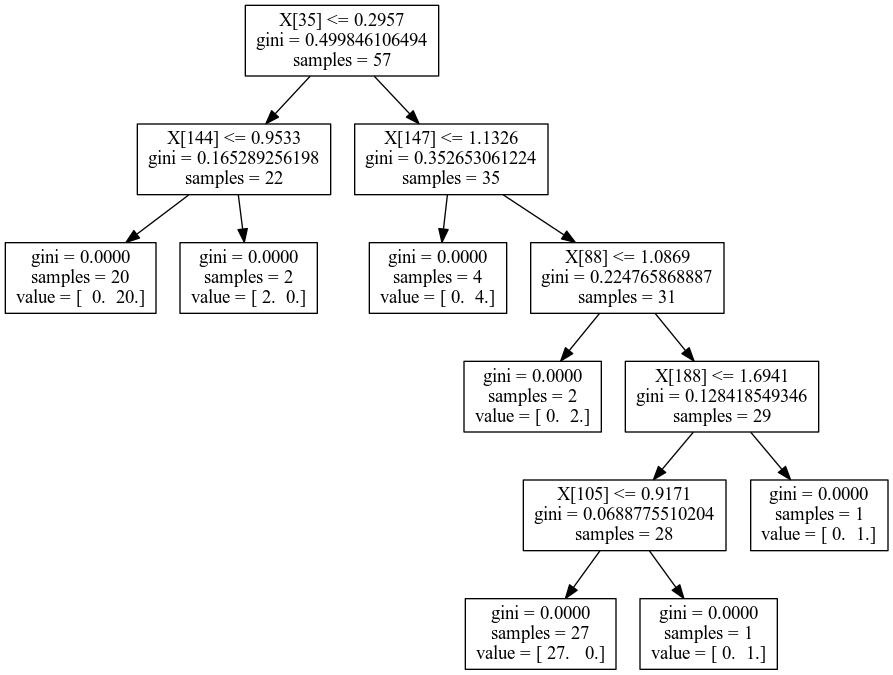

In [5]:
dot_data = StringIO() 
tree.export_graphviz(clf_tree, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
fout = tempfile.NamedTemporaryFile(suffix=".png")
graph.write(fout.name, format="png")
Image(filename=fout.name)